<a href="https://colab.research.google.com/github/anhadh3101/HAR/blob/main/HAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing necessary libraries

In [ ]:
!pip install tensorflow tensorflow-addons Pillow

In [ ]:
import os
import glob
import random
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_addons as tfa
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Rescaling
from keras import layers
import torch
import torchvision.models as models
from torchvision import transforms

from PIL import Image

from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

# Loading the dataset
1. Add the training dataset's zip file to your google drive.
2. Mount the google drive to the colab notebook by running the first code setion.
3. Unzip the file to the local environment by running the second code section. (Set the path to the dataset accordingly)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!unzip gdrive/My\ Drive/archive.zip

# Preprocessing the data

1. Preprocess the images by resizing them to 160x160 pixels for the training data. We will normalize the images in the model itself because the runtime keeps crashing.
2. Split the data into training, validation and testing set.

Getting the paths to the dataset

In [5]:
# Getting paths to training and testing images.
train_fol = '/content/Human Action Recognition/train'
test_fol = '/content/Human Action Recognition/test'

# Getting paths to csv files.
train_csv = '/content/Human Action Recognition/Training_set.csv'
test_csv = '/content/Human Action Recognition/Testing_set.csv'

In [6]:
# Store the csv file as a Pandas dataframe.
train_data = pd.read_csv(train_csv)

# Get the columns of the dataframe.
train_filenames = train_data['filename']
train_labels = train_data['label']

Preprocessing the images

In [7]:
# Store the preprocessed arrays of images.
resized_images = []

# Go through each image and store the corresponding array.
for i in range(len(train_data)):
  img = Image.open(os.path.join(train_fol + "/" + train_filenames[i])) # Get the image.
  # Split the image into its red, green and blue components and store it in an array.
  resized_images.append(np.asarray(img.resize((160, 160)))) # Convert and store the image.

# Convert the array into a Numpy array.
x_train = np.asarray(resized_images)

In [8]:
# Convert the label to a Numpy array.
y_train = to_categorical(np.asarray(train_data['label'].factorize()[0]))

In [9]:
# Spliting the training set into training and validation set for custom model.
xc_train, x_val, yc_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [10]:
# Storing the paths to test images in an array.
test_data = pd.read_csv(test_csv)
test_filenames = test_data['filename']
test_paths = []
for i in range(len(test_data)):
  test_paths.append(test_fol + '/' + test_filenames[i])

# Custom Model

In [11]:
# Creating our own CNN model.
# Using Batch Normalization makes the neural network faster. It is used to
# substitute the process of image normalization to bypass the errors caused by
# the limitations on the resources.
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(15, activation='softmax')
])

In [ ]:
# Compiling the model.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# Training the model based with batches for memory efficiency.
history = model.fit(xc_train, yc_train, epochs=3, batch_size=16, validation_data=(x_val, y_val))

## Making model

In [ ]:
efficientnet_model = Sequential()

model = tf.keras.applications.EfficientNetB7(include_top=False,
                                            input_shape=(160,160,3),
                                            pooling ="avg",classes=15,
                                             weights="imagenet")

for layer in model.layers:
    layer.trainable=False


efficientnet_model.add(model)
efficientnet_model.add(Flatten())
efficientnet_model.add(Dense(512,activation="relu"))
efficientnet_model.add(Dense(15,activation="softmax"))

In [ ]:
efficientnet_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
efficientnet_model.summary()

In [ ]:
history = efficientnet_model.fit(x_train,y_train,epochs=40)

In [ ]:
losses = history.history["loss"]
plt.plot(losses)

In [ ]:
acc = history.history['accuracy']
plt.plot(acc)

## Model predictions

In [ ]:
def read_img(fn):
    img = Image.open(fn)
    return np.asarray(img.resize((160,160)))

In [ ]:
def test_predict(test_image):
    result = efficientnet_model.predict(np.asarray([read_img(test_image)]))

    itemindex = np.where(result==np.max(result))
    prediction = itemindex[1][0]
    print("probability: "+str(np.max(result)*100) + "%\nPredicted class : ", prediction)

    image = img.imread(test_image)
    plt.imshow(image)
    plt.title(prediction)

In [ ]:
test_predict('/content/Human Action Recognition/test/Image_1001.jpg')

In [ ]:
test_predict('/content/Human Action Recognition/test/Image_101.jpg')

# Using Pretrained Models

## 1. ResNet50

In [ ]:
# Intializing a Sequential model to .
resnet50 = Sequential()

# Getting a pretrained ResNet50 model.
pretrained_resnet50 = tf.keras.applications.ResNet50(
  include_top=False,
  input_shape=(160, 160, 3),
  pooling='avg',
  classes=15, # Initialized the number of classes in the dataset.
  weights='imagenet'
)

# Freezing the weights of the pretrained model to avoid retraining.
for layer in pretrained_resnet50.layers:
  layer.trainable = False

# Adding the pretrained model and additional layers to the Sequential model.
resnet50.add(pretrained_resnet50)
# resnet50.add(Flatten())
# resnet50.add(Dense(512, activation='relu'))
resnet50.add(Dense(15, activation='softmax')) # Predicts one of 15 labels.

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Compiling the model
resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
resnet50.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 15)                30735     
                                                                 
Total params: 23618447 (90.10 MB)
Trainable params: 30735 (120.06 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
# Training the model
history = resnet50.fit(x_train, y_train, epochs=10)

Epoch 1/10
394/394 [==============================] - 24s 60ms/step - loss: 1.6504 - accuracy: 0.4833
Epoch 2/10
394/394 [==============================] - 22s 57ms/step - loss: 1.2247 - accuracy: 0.6053
Epoch 3/10
394/394 [==============================] - 22s 56ms/step - loss: 1.0601 - accuracy: 0.6559
Epoch 4/10
394/394 [==============================] - 23s 58ms/step - loss: 0.9708 - accuracy: 0.6795
Epoch 5/10
394/394 [==============================] - 22s 56ms/step - loss: 0.8934 - accuracy: 0.7085
Epoch 6/10
394/394 [==============================] - 22s 56ms/step - loss: 0.8193 - accuracy: 0.7260
Epoch 7/10
394/394 [==============================] - 22s 56ms/step - loss: 0.7635 - accuracy: 0.7485
Epoch 8/10
394/394 [==============================] - 22s 57ms/step - loss: 0.7047 - accuracy: 0.7664
Epoch 9/10
394/394 [==============================] - 22s 56ms/step - loss: 0.6804 - accuracy: 0.7728
Epoch 10/10
394/394 [==============================] - 22s 56ms/step - loss: 0.635

1/1 [==============================] - 0s 18ms/step
0


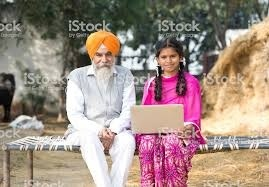

In [ ]:
test_img = Image.open(test_paths[335])
a = np.asarray(test_img.resize((160, 160)))
result = model.predict(np.asarray([a]))
item_index = np.where(result == np.max(result))
print(item_index[1][0])
# result2 = resnet50.predict(np.asarray([a]))
# item_index2 = np.where(result == np.max(result))
# print(item_index2[1][0])
# print(type(train_data['label']))
test_img

## 2. AlexNet

In [ ]:
# Preprocessing and transformations for images
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Loading AlexNet pretrained model
alexnet_model = models.alexnet(pretrained=True)
alexnet_model.eval()  # Setting the model to evaluation mode

In [ ]:
# Function to get prediction
def get_prediction(img_path, model):
    input_image = Image.open(img_path)
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    # Using the model to get prediction
    with torch.no_grad():
        output = model(input_batch)
    return output[0]

In [ ]:
# Loop through all image files in the test directory
for filename in test_data['filename']:
    # Construct the path to the current image file
    test_image_path = os.path.join(test_fol, filename)

    # Get prediction for the current image file
    prediction = get_prediction(test_image_path, alexnet_model)
    probabilities = torch.nn.functional.softmax(prediction, dim=0)
    print(probabilities)